# MNIST with `Estimator`
The purpose of this notebook is to convert the `keras` implementation of MNIST MLP in the notebook cpu-gpu-mnist into an `Estimator` implementation, which will be faster and will be an important step along the way to implementing MNIST for TPUs.

I'm getting a lot of my code from [this](https://towardsdatascience.com/first-contact-with-tensorflow-estimator-69a5e072998d) tutorial on estimators, plus some extra code on inferences from [this](https://medium.com/@vincentteyssier/tensorflow-estimator-tutorial-on-real-life-data-aa0fca773bb) blog.

## Setup
First, we import the required libraries.

In [20]:
import os
import sys
import time
import tensorflow as tf
import numpy as np

# Disable depreciation warnings and limit verbosity during training
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.logging.set_verbosity(0)

Now we create some global variables which will define the learning process. Those in the first bock are set to be identical to the corresponding global variables in the `keras` implementation of MNIST in this repository.

In [21]:
NUM_CLASSES = 10
NUM_CHANNELS = 1
NUM_EPOCHS = 5
IMG_EDGE = 28

We must download the MNIST dataset. We will download it in its orginal form, fitted neither to MLP format nor CNN format. We will reformat it for each of these implementations later. 

In [22]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns a np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns a np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
print()
print("Train dataset size:", train_data.shape[0])
print("Eval dataset size:", eval_data.shape[0])

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz

Train dataset size: 55000
Eval dataset size: 10000


We also need a function to describe the behavior of the `Estimator` during evaluation.

In [23]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x=eval_data,
        y=eval_labels,
        num_epochs=1,
        shuffle=False)

## Run
Now we will create a superclass &mdash; much like we did in the `keras` implementation of MNIST in this repository &mdash; which contains all of the functions common to both MLP and CNN implementations of MNIST. The methods of this superclass are described as follows:
- `__init__` simply sets the device to use, either CPU or GPU so that it is consistent throughout the whole process of training and predicting on the `Estimator`.
- `_load` perfoms all the implementation-specific functions, such as determining the topology of the neural net, and reshaping the data.
- `model_fn` is a required argument of `tf.estimator.Estimator.__init__` which describes the behavior of the `Estimator`. 
- `_train` will train the `Estimator` and return the time per iteration it takes to do so, just as it did in the `keras` implementation of MNIST in this repository.
- `_predict` does the same but for inference. It will return the time it takes to do inference on the `Estimator` per inference, where the batch size refers to the number of inferences to do in parallel.
- `_main` is the function that the `tensorflow` app runs, which calls `_train` and `_predict` and gathers all the data into `self.train_times` and `self.inference_times`.
- `get_data` is the only "public" function &mdash; the only one which is called outside of the class. It calls `_main`.

In [27]:
batch_train_data = []
batch_inference_data = []

class MNIST:
    def __init__(self, device):
        self.device = device
        self.learning_rate = None
        self.start_power = 0
        self.end_power = 0
    
    # To be overrided
    def _load(self, features):
        return None, None
    
    def _get_batch_sizes(self):
        self.batch_sizes = []
        for i in range(self.start_power, self.end_power):
            self.batch_sizes += list(range(10**i, 10**(i+1), 10**i))
        self.batch_sizes += [10**self.end_power]
        
    def model_fn(self, features, labels, mode):
        '''
        Arguments:
            features: items returned from input_fn
            labels: second item returned from input_fn
            mode: the mode the estimator is running in (basically training, validation or prediction). Either
                - tf.estimator.ModeKeys.TRAIN
                - tf.estimator.ModeKeys.EVAL
                - tf.estimator.ModeKeys.PREDICT
        Returns:
            tf.estimator.EstimatorSpec containing
                - the train/loss ops for training
                - loss and metrics for evaluation
                - predictions for inference
        '''
        with tf.device(self.device):
            global_step=tf.train.get_global_step()

            model, images = self._load(features)
            if model == None:
                raise Exception("The class MNIST is not meant to be instantiated.")

            logits = model(images)
            predicted_logit = tf.argmax(input=logits, axis=1, 
                                        output_type=tf.int32)
            probabilities = tf.nn.softmax(logits)

            #PREDICT
            predictions = {
              "predicted_logit": predicted_logit,
              "probabilities": probabilities
            }
            if mode == tf.estimator.ModeKeys.PREDICT:
                return tf.estimator.EstimatorSpec(mode=mode,  
                                                predictions=predictions)
            with tf.name_scope('loss'):
                cross_entropy = tf.losses.sparse_softmax_cross_entropy(
                        labels=labels, logits=logits, scope='loss')
                tf.summary.scalar('loss', cross_entropy)
            with tf.name_scope('accuracy'):
                accuracy = tf.metrics.accuracy(
                        labels=labels, predictions=predicted_logit, name='acc')
                tf.summary.scalar('accuracy', accuracy[1])
                #EVAL
                if mode == tf.estimator.ModeKeys.EVAL:
                    return tf.estimator.EstimatorSpec(
                        mode=mode,
                        loss=cross_entropy,
                        eval_metric_ops={'accuracy/accuracy': accuracy},
                        evaluation_hooks=None)


            # Create a SGR optimizer 
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)
            train_op = optimizer.minimize( 
                        cross_entropy,global_step=global_step)

            # Create a hook to print acc, loss & global step every 100 iter.   
            train_hook_list= []
            train_tensors_log = {'accuracy': accuracy[1],
                                 'loss': cross_entropy,
                                 'global_step': global_step}
            train_hook_list.append(tf.train.LoggingTensorHook(
                tensors=train_tensors_log, every_n_iter=100))

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(
                  mode=mode,
                  loss=cross_entropy,
                  train_op=train_op,
                  training_hooks=train_hook_list)

    def _train(self, batch_size):
        # train_input_fn must be redefined for every batch size.
        train_input_fn = tf.estimator.inputs.numpy_input_fn(
            x=train_data,
            y=train_labels,
            batch_size=batch_size,
            num_epochs=1,
            shuffle=True)

        start_time = time.time()
        for i in range(NUM_EPOCHS):
            epoch_start_time = time.time()
            print("Epoch " + str(i+1) + '/' + str(NUM_EPOCHS)+': ', end = '')
            self.image_classifier.train(input_fn=train_input_fn)
            metrics = self.image_classifier.evaluate(input_fn=eval_input_fn)
            epoch_end_time = time.time()
            print('Accuracy:', metrics['accuracy/accuracy'], '\tLoss:', metrics['loss'],
                  '\tTime:', epoch_end_time - epoch_start_time, 's')
        end_time = time.time()
        iterations = NUM_EPOCHS * (train_data.shape[0] / batch_size)
        train_time = (end_time - start_time) / iterations
        return train_time
    
    def _predict(self, batch_size):
        inference_time = 0
        inference_num = 0
        start_inference = time.time()
        while True:
            # Remade every iteration to randomize
            predict_data = np.random.rand(batch_size, IMG_EDGE**2).astype('float32')
            predict_input_fn = tf.estimator.inputs.numpy_input_fn(
                x=predict_data,
                y=None,
                batch_size=batch_size,
                num_epochs=1,
                shuffle=True)
        
            start_time = time.time()
            preds = self.image_classifier.predict(predict_input_fn)
            for i in range(batch_size):
                s = next(preds)
            end_time = time.time()
            inference_time += end_time - start_time
            inference_num += 1
            if end_time - start_inference > 5:# Don't let inference take longer than 5 seconds
                break
        inference_time = inference_time / inference_num / batch_size
        return inference_time, inference_num
    
    def _main(self, _):
        self.train_times = []
        self.inference_times = []
        self._get_batch_sizes()
        for batch_size in self.batch_sizes:
            self.image_classifier = tf.estimator.Estimator(model_fn=self.model_fn, model_dir=None)
                # set model_dir to make model progress permanent
            train_time = self._train(batch_size)
            inference_time, inference_num = self._predict(batch_size)
            print('\n','Batch size:', batch_size, '\tTrain time:', train_time, '\tInference time', inference_time, '(%s)'%inference_num)
            print('+'*100)
            self.train_times.append(train_time)
            self.inference_times.append(inference_time)
            
    def get_data(self):
        try:
            tf.app.run(self._main)
        except SystemExit:
            # Prevent the program from exiting when done
            pass

With the superclass defined, we must now implement it for MLP and CNN versions of MNIST. For each, we define a class which contains the topology of the MNIST neural net (e.g., `ModelMLP`), and then we implement a subclass of the class `MNIST` we just defined which returns it (e.g., `MNIST_MLP`).

In [28]:
class ModelMLP(object):
    def __call__(self, inputs):
        net = tf.layers.dense(inputs, 512, activation=tf.nn.relu, name='dense1')
        net = tf.layers.dropout(net, rate=0.2, name='drop1')
        net = tf.layers.dense(net, 512, activation=tf.nn.relu, name='dense2')
        net = tf.layers.dropout(net, rate=0.2, name='drop2')
        net = tf.layers.dense(net, NUM_CLASSES, activation=tf.nn.softmax, name='dense3')
        return net
    
class MNIST_MLP(MNIST):
    def _load(self, features):
        images = tf.reshape(features, [-1, IMG_EDGE**2])
        self.learning_rate = 0.001# Learning rate from keras.optimizers.RMSprop
        self.start_power = 0
        self.end_power = 4
        return ModelMLP(), images

In [14]:
class ModelCNN(object):
    def __call__(self, inputs):
        net = tf.layers.conv2d(inputs, 32, [5, 5], activation=tf.nn.relu, name='conv1')
        net = tf.layers.max_pooling2d(net, [2, 2], 2, name='pool1')
        net = tf.layers.conv2d(net, 64, [5, 5], activation=tf.nn.relu, name='conv2')
        net = tf.layers.max_pooling2d(net, [2, 2], 2, name='pool2')
        net = tf.layers.flatten(net)
        net = tf.layers.dense(net, NUM_CLASSES, activation=None, name='fc1')
        return net
          
class MNIST_CNN(MNIST):
    def _load(self, features):
        images = tf.reshape(features, [-1, IMG_EDGE, IMG_EDGE, NUM_CHANNELS])
        self.learning_rate = 1.0# Learning rate from keras.optimizers.Adadelta
        self.start_power = 0
        self.end_power = 2 # CNN nets are bigger, and for high batch size they run out of memory.
        return ModelCNN(), images

With the subclasses implemented, all we need to do is instantiate them and call `get_data` for both. This will train all the models and run all the inferences for all the batch sizes we need, with all possible combinations of machine type (CPU or GPU) and MNIST implementation (MLP or CNN).

In [29]:
print("MNIST MLP")
print()
mlp_cpu = MNIST_MLP('/cpu:0')
mlp_gpu = MNIST_MLP('/gpu:0')

print()
print("TRAIN ON CPUS")
print()
print('+'*100)
mlp_cpu.get_data()
 
print()
print("TRAIN ON GPUS")
print()
print('+'*100)
mlp_gpu.get_data()

print()
print('+'*47, "DONE", '+'*47)

MNIST MLP


TRAIN ON CPUS

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/1: Accuracy: 0.1249 	Loss: 2.3015165 	Time: 7.791540145874023 s

 Batch size: 500 	Train time: 0.07083218314430931 	Inference time 0.0008475411335627238 (12)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/1: Accuracy: 0.0872 	Loss: 2.302601 	Time: 7.232938528060913 s

 Batch size: 400 	Train time: 0.052618458487770775 	Inference time 0.0010874479015668232 (12)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/1: Accuracy: 0.1408 	Loss: 2.300237 	Time: 7.356692552566528 s

 Batch size: 300 	Train time: 0.040127413923090154 	Inference time 0.0013965925243165757 (12)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/1: Accuracy: 0.1037 	Loss: 2.3028004 	Time: 7.852348804473877 s

In [16]:
print("MNIST CNN")
print()
cnn_cpu = MNIST_CNN('/cpu:0')
cnn_gpu = MNIST_CNN('/gpu:0')

print()
print("TRAIN ON CPUS")
print()
print('+'*100)
cnn_cpu.get_data()
 
print()
print("TRAIN ON GPUS")
print()
print('+'*100)
cnn_gpu.get_data()

print()
print('+'*47, "DONE", '+'*47)

MNIST CNN


TRAIN ON CPUS

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/5: Accuracy: 0.1028 	Loss: 2.3043876 	Time: 60.075186014175415 s
Epoch 2/5: Accuracy: 0.1135 	Loss: 2.303211 	Time: 60.213101387023926 s
Epoch 3/5: Accuracy: 0.1135 	Loss: 2.3026192 	Time: 60.74063467979431 s
Epoch 4/5: Accuracy: 0.1028 	Loss: 2.3035023 	Time: 61.052990436553955 s
Epoch 5/5: Accuracy: 0.1135 	Loss: 2.3022842 	Time: 67.24077558517456 s

 Batch size: 128 	Train time: 0.1439845352450284 	Inference time 0.009331591054797172 (5)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

TRAIN ON GPUS

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/5: Accuracy: 0.1135 	Loss: 2.302556 	Time: 82.41157913208008 s
Epoch 2/5: Accuracy: 0.1028 	Loss: 2.304377 	Time: 83.03692507743835 s
Epoch 3/5: Accuracy: 0.101 	Loss: 2.3035338 	Time: 70.43006

## Graphing Data
Now we will graph the data we have collected above. First we import the `matplotlib` libraries.

In [70]:
import numpy as np
import matplotlib.pyplot as plt

x_mlp = np.array(mlp_cpu.batch_sizes)
x_cnn = np.array(cnn_cpu.batch_sizes)

Then we plot the train time and inference times on CPUs and GPUs as a function of batch size. This is train time.

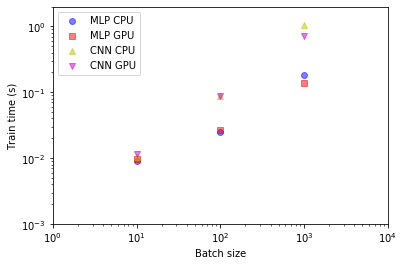

In [71]:
plt.scatter(x_mlp, mlp_cpu.train_times, c='b', alpha = 0.5)
plt.scatter(x_mlp, mlp_gpu.train_times, c='r', alpha = 0.5, marker='s')
plt.scatter(x_cnn, cnn_cpu.train_times, c='y', alpha = 0.5, marker='^')
plt.scatter(x_cnn, cnn_gpu.train_times, c='m', alpha = 0.5, marker='v')
plt.xlabel('Batch size')
plt.ylabel('Train time (s)')
plt.xscale('log')
plt.yscale('log')
plt.axis([1, 10000, 0.001, 2])
plt.legend(['MLP CPU', 'MLP GPU', 'CNN CPU', 'CNN GPU'])
plt.show()

This is inference time:

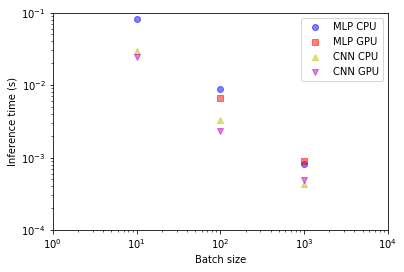

In [72]:
plt.scatter(x_mlp, mlp_cpu.inference_times, c='b', alpha = 0.5)
plt.scatter(x_mlp, mlp_gpu.inference_times, c='r', alpha = 0.5, marker='s')
plt.scatter(x_cnn, cnn_cpu.inference_times, c='y', alpha = 0.5, marker='^')
plt.scatter(x_cnn, cnn_gpu.inference_times, c='m', alpha = 0.5, marker='v')
plt.xlabel('Batch size')
plt.ylabel('Inference time (s)')
plt.xscale('log')
plt.yscale('log')
plt.axis([1, 10000, 0.0001, 0.1])
plt.legend(['MLP CPU', 'MLP GPU', 'CNN CPU', 'CNN GPU'])
plt.show()

We can also plot the performance gain in using GPUs over CPUs. This is performance gain in train time.

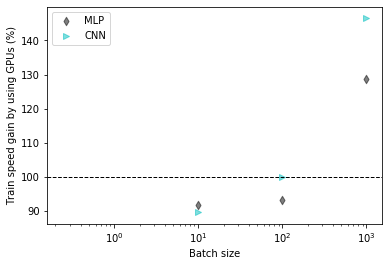

In [73]:
def get_improvement(cpu_times, gpu_times):
    gain = []
    for i in range(len(cpu_times)):
        gain.append(cpu_times[i] / gpu_times[i] * 100)
    return np.array(gain)

gain_train_mlp = get_improvement(mlp_cpu.train_times, mlp_gpu.train_times)
gain_train_cnn = get_improvement(cnn_cpu.train_times, cnn_gpu.train_times)

plt.scatter(x_mlp, gain_train_mlp, c='k', alpha = 0.5, marker = 'd')
plt.scatter(x_cnn, gain_train_cnn, c='c', alpha = 0.5, marker = '>')
plt.xlabel('Batch size')
plt.ylabel('Train speed gain by using GPUs (%)')
plt.xscale('log')
plt.yscale('linear')
plt.legend(['MLP', 'CNN'])
plt.axhline(100, linestyle='--', linewidth=1, color='k')
plt.show()

This is the performance gain in inference time.

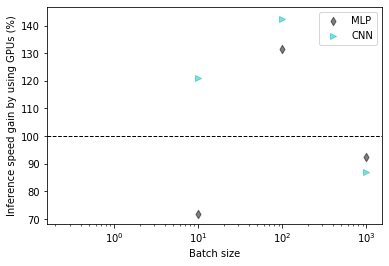

In [74]:
gain_inference_mlp = get_improvement(mlp_cpu.inference_times, mlp_gpu.inference_times)
gain_inference_cnn = get_improvement(cnn_cpu.inference_times, cnn_gpu.inference_times)

plt.scatter(x_mlp, gain_inference_mlp, c='k', alpha = 0.5, marker='d')
plt.scatter(x_cnn, gain_inference_cnn, c='c', alpha = 0.5, marker='>')
plt.xlabel('Batch size')
plt.ylabel('Inference speed gain by using GPUs (%)')
plt.xscale('log')
plt.yscale('linear')
plt.legend(['MLP', 'CNN'])
plt.axhline(100, linestyle='--', linewidth=1, color='k')
plt.show()

This concludes the experiment.